# Aggregation and Grouping

In [1]:
import numpy as np
import pandas as pd

class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)


## Planets data

In [2]:
import seaborn as sns
planets = sns.load_dataset('planets')
planets.shape

(1035, 6)

In [3]:
planets.head()

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300,7.10,77.40,2006
1,Radial Velocity,1,874.774,2.21,56.95,2008
2,Radial Velocity,1,763.000,2.60,19.84,2011
3,Radial Velocity,1,326.030,19.40,110.62,2007
4,Radial Velocity,1,516.220,10.50,119.47,2009


## Simple aggregation

In [4]:
rng = np.random.RandomState(42)
ser = pd.Series(rng.rand(5))
ser

0    0.374540
1    0.950714
2    0.731994
3    0.598658
4    0.156019
dtype: float64

In [5]:
ser.sum()

2.811925491708157

In [6]:
ser.mean()

0.5623850983416314

In [7]:
df = pd.DataFrame({'A': rng.rand(5),
                   'B': rng.rand(5)})
df

,A,B
0,0.155995,0.020584
1,0.058084,0.969910
2,0.866176,0.832443
3,0.601115,0.212339
4,0.708073,0.181825


In [8]:
df.mean() # ==df.mean(0)

A    0.477888
B    0.443420
dtype: float64

In [9]:
df.mean(axis='columns')

0    0.088290
1    0.513997
2    0.849309
3    0.406727
4    0.444949
dtype: float64

In [10]:
planets.dropna().describe()

,number,orbital_period,mass,distance,year
count,498.00000,498.000000,498.000000,498.000000,498.000000
mean,1.73494,835.778671,2.509320,52.068213,2007.377510
std,1.17572,1469.128259,3.636274,46.596041,4.167284
min,1.00000,1.328300,0.003600,1.350000,1989.000000
25%,1.00000,38.272250,0.212500,24.497500,2005.000000
50%,1.00000,357.000000,1.245000,39.940000,2009.000000
75%,2.00000,999.600000,2.867500,59.332500,2011.000000
max,6.00000,17337.500000,25.000000,354.000000,2014.000000


**Aggregation	Description**<br>
count()	Total number of items<br>
first(), last()	First and last item<br>
mean(), median()	Mean and median<br>
min(), max()	Minimum and maximum<br>
std(), var()	Standard deviation and variance<br>
mad()	Mean absolute deviation<br>
prod()	Product of all items<br>
sum()	Sum of all items<br>

# GroupBy: Split, Apply, Combine

Simple example of the split-apply-combine operation, where the apply is a summation:

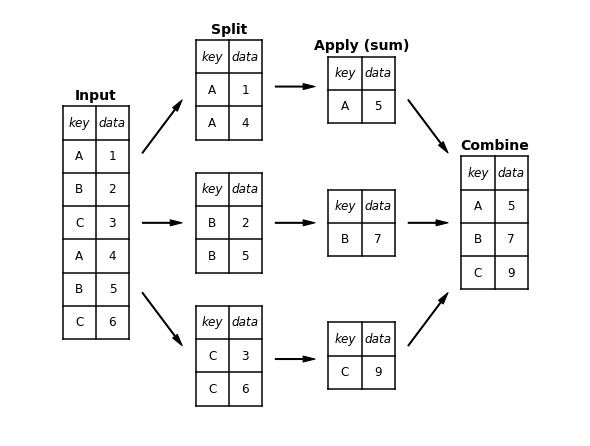

In [12]:
from splitapplycombine import Draw
Draw.draw()

GroupBy does all of these steps, meaning we can abstract away

In [13]:
df = pd.DataFrame({'key': ['A', 'B', 'C', 'A', 'B', 'C'],
                   'data': range(6)}, columns=['key', 'data'])
df

,key,data
0,A,0
1,B,1
2,C,2
3,A,3
4,B,4
5,C,5


In [14]:
df.groupby('key')

This is where the magic is - it's a special view of the DataFrame, which is poised to dig into the groups but does no actual computation until the aggregation is applied.

In [15]:
df.groupby('key').sum()

,data
key,
A,3
B,5
C,7


Can apply virtually any Pandas or NumPy operation, as well any valid Dataframe operation.

## The GroupBy object

Very flexible abstraction - can treat it as a collection of Dataframes, with the work happening under the hood. Most import operations are aggregate, filter, transform and apply which we'll see later.

### Column indexing

We can index by column in the same way as a Dataframe

In [18]:
planets.head()

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300,7.10,77.40,2006
1,Radial Velocity,1,874.774,2.21,56.95,2008
2,Radial Velocity,1,763.000,2.60,19.84,2011
3,Radial Velocity,1,326.030,19.40,110.62,2007
4,Radial Velocity,1,516.220,10.50,119.47,2009


In [19]:
planets.groupby('method')

In [20]:
planets.groupby('method')['orbital_period']

In [21]:
planets.groupby('method')['orbital_period'].median()

method
Astrometry                         631.180000
Eclipse Timing Variations         4343.500000
Imaging                          27500.000000
Microlensing                      3300.000000
Orbital Brightness Modulation        0.342887
Pulsar Timing                       66.541900
Pulsation Timing Variations       1170.000000
Radial Velocity                    360.200000
Transit                              5.714932
Transit Timing Variations           57.011000
Name: orbital_period, dtype: float64

### Iteration over groups

We can directly iterate, which returns each group as a Series or DataFrame

In [22]:
for (method, group) in planets.groupby('method'):
    print("{0:30s} shape={1}".format(method, group.shape))

Astrometry                     shape=(2, 6)
Eclipse Timing Variations      shape=(9, 6)
Imaging                        shape=(38, 6)
Microlensing                   shape=(23, 6)
Orbital Brightness Modulation  shape=(3, 6)
Pulsar Timing                  shape=(5, 6)
Pulsation Timing Variations    shape=(1, 6)
Radial Velocity                shape=(553, 6)
Transit                        shape=(397, 6)
Transit Timing Variations      shape=(4, 6)


Can be faster to use the apply method instead.

### Dispatch methods

Through some Python class magic, any method not explicitly implemented will be passed through and called on the groups, whether or not they are DataFrame or Series objects, e.g:

In [26]:
planets.groupby('method')['year'].describe()

,count,mean,std,min,25%,50%,75%,max
method,,,,,,,,
Astrometry,2.0,2011.500000,2.121320,2010.0,2010.75,2011.5,2012.25,2013.0
Eclipse Timing Variations,9.0,2010.000000,1.414214,2008.0,2009.00,2010.0,2011.00,2012.0
Imaging,38.0,2009.131579,2.781901,2004.0,2008.00,2009.0,2011.00,2013.0
Microlensing,23.0,2009.782609,2.859697,2004.0,2008.00,2010.0,2012.00,2013.0
Orbital Brightness Modulation,3.0,2011.666667,1.154701,2011.0,2011.00,2011.0,2012.00,2013.0
Pulsar Timing,5.0,1998.400000,8.384510,1992.0,1992.00,1994.0,2003.00,2011.0
Pulsation Timing Variations,1.0,2007.000000,NaN,2007.0,2007.00,2007.0,2007.00,2007.0
Radial Velocity,553.0,2007.518987,4.249052,1989.0,2005.00,2009.0,2011.00,2014.0
Transit,397.0,2011.236776,2.077867,2002.0,2010.00,2012.0,2013.00,2014.0


They are applied to each individual group, and the results are combined within GroupBy and returned. 

### Aggregate, filter, transform, apply

These four methods efficiently implement useful operations before combining the grouped data.

In [27]:
rng = np.random.RandomState(0)
df = pd.DataFrame({'key': ['A', 'B', 'C', 'A', 'B', 'C'],
                   'data1': range(6),
                   'data2': rng.randint(0, 10, 6)},
                   columns = ['key', 'data1', 'data2'])
df

,key,data1,data2
0,A,0,5
1,B,1,0
2,C,2,3
3,A,3,3
4,B,4,7
5,C,5,9


### Aggreagation

aggregate() takes a string, function or a list thereof, and computes all the aggregates at once e.g.:

In [28]:
df.groupby('key').aggregate(['min', np.median, max])

data1            data2           
      min median max   min median max
key                                  
A       0    1.5   3     3    4.0   5
B       1    2.5   4     0    3.5   7
C       2    3.5   5     3    6.0   9

Another pattern uses dictionarys to choose which operation to perform:

In [29]:
df.groupby('key').aggregate({'data1': 'min',
                             'data2': 'max'})

,data1,data2
key,,
A,0,5
B,1,7
C,2,9


### Filtering

This allows us to drop data based on group properties. For example, we might want to keep all groups with std dev larger than some value:

In [31]:
def filter_func(x):
    return x['data2'].std() > 4

display('df', "df.groupby('key').std()", "df.groupby('key').filter(filter_func)")

df
  key  data1  data2
0   A      0      5
1   B      1      0
2   C      2      3
3   A      3      3
4   B      4      7
5   C      5      9

df.groupby('key').std()
       data1     data2
key                   
A    2.12132  1.414214
B    2.12132  4.949747
C    2.12132  4.242641

df.groupby('key').filter(filter_func)
  key  data1  data2
1   B      1      0
2   C      2      3
4   B      4      7
5   C      5      9

### Transformation

aggregation returns a reduced version of the data, whereas transform can return some transformed version of the full data to recombine. The output shape is the same as the input:

In [32]:
df.groupby('key').transform(lambda x: x - x.mean())

,data1,data2
0,-1.5,1.0
1,-1.5,-3.5
2,-1.5,-3.0
3,1.5,-1.0
4,1.5,3.5
5,1.5,3.0


### The apply() method

apply lets you apply an arbitrary function to the group results. The function should take a DataFrame, and return eitehr a Pandas object, or a scalar, e.g. normalising the first column by sum of second:

In [33]:
def norm_by_data2(x):
    # x is a Dataframe of group values
    x['data1'] /= x['data2'].sum()
    return x

display('df', "df.groupby('key').apply(norm_by_data2)")

,key,data1,data2
0,A,0,5
1,B,1,0
2,C,2,3
3,A,3,3
4,B,4,7
5,C,5,9
,key,data1,data2
0,A,0.000000,5
1,B,0.142857,0
2,C,0.166667,3


Apply can be used on the whole grouped DataFrame at one time, whereas transform only works on one column at a time, and has to return the same shaped DataFrame.

## Specifying the split key

### A list, array, series or index providing the group keys

Each of the values corresponds to the group to put the row in

In [36]:
L = [0, 1, 0, 1, 2, 0]
display('df', "df.groupby(L).sum()")

df
  key  data1  data2
0   A      0      5
1   B      1      0
2   C      2      3
3   A      3      3
4   B      4      7
5   C      5      9

df.groupby(L).sum()
   data1  data2
0      7     17
1      4      3
2      4      7

This means we can do df.groupby('key') more verbosely:

In [38]:
display('df', "df.groupby(df['key']).sum()")

df
  key  data1  data2
0   A      0      5
1   B      1      0
2   C      2      3
3   A      3      3
4   B      4      7
5   C      5      9

df.groupby(df['key']).sum()
     data1  data2
key              
A        3      8
B        5      7
C        7     12

### Dictionary or series mapping index to group

In [46]:
df2 = df.set_index('key')
mapping = {'A': 'vowel', 'B': 'consonant', 'C': 'consonant'}
display('df2', 'df2.groupby(mapping).sum()')
# not sure why this isn't working as I'd expect

,data1,data2
key,,
A,0,5
B,1,0
C,2,3
A,3,3
B,4,7
C,5,9
,data1,data2
consonant,12,19
vowel,3,8


### Any Python function

In [48]:
display('df2', 'df2.groupby(str.lower).mean()')

,data1,data2
key,,
A,0,5
B,1,0
C,2,3
A,3,3
B,4,7
C,5,9
,data1,data2
a,1.5,4.0
b,2.5,3.5


## Grouping example

In [49]:
planets.head()

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300,7.10,77.40,2006
1,Radial Velocity,1,874.774,2.21,56.95,2008
2,Radial Velocity,1,763.000,2.60,19.84,2011
3,Radial Velocity,1,326.030,19.40,110.62,2007
4,Radial Velocity,1,516.220,10.50,119.47,2009


In [52]:
decade = 10 * (planets['year'] // 10)
decade = decade.astype('str') + 's'
decade.name = 'decade'
planets.groupby(['method', decade])['number'].sum().unstack().fillna(0)

decade,1980s,1990s,2000s,2010s
method,,,,
Astrometry,0.0,0.0,0.0,2.0
Eclipse Timing Variations,0.0,0.0,5.0,10.0
Imaging,0.0,0.0,29.0,21.0
Microlensing,0.0,0.0,12.0,15.0
Orbital Brightness Modulation,0.0,0.0,0.0,5.0
Pulsar Timing,0.0,9.0,1.0,1.0
Pulsation Timing Variations,0.0,0.0,1.0,0.0
Radial Velocity,1.0,52.0,475.0,424.0
Transit,0.0,0.0,64.0,712.0
